# Text Classification:  Quora questions pairs 
In this notebook we work on a Kaggle competition problem in which we are trying to answer the following question: Can you identify question pairs that have the same intent?

https://www.kaggle.com/c/quora-question-pairs

In [25]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# pytorch modules
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


from pathlib import Path
import random
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

## First look at the data

In [3]:
#path = "/data/yinterian/quora-question-pairs/"
PATH = Path("/Users/yinterian/teaching/data/quora-question-pairs/")

In [3]:
!head $PATH/train.csv

In [19]:
data = pd.read_csv(PATH/"train.csv")
test = pd.read_csv(PATH/"test.csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## Tokenizing
Before we can analyze text, we must first tokenize it. Tokenization is the process to split text into tokens.

You can install spacy in mac by running

`conda install -c conda-forge spacy`

In [15]:
import spacy
import string
import re
from spacy.symbols import ORTH

In [16]:
# first time run this
#!python3 -m spacy download en

In [17]:
# borrowed from fast.ai (https://github.com/fastai/fastai/blob/master/fastai/nlp.py)
re_br = re.compile(r'<\s*br\s*/?>', re.IGNORECASE)
def sub_br(x): return re_br.sub("\n", x)

my_tok = spacy.load('en')
def spacy_tok(x): return [tok.text for tok in my_tok.tokenizer(sub_br(x))]

In [20]:
row = data.iloc[0]
spacy_tok(row['question1'].lower())

['what',
 'is',
 'the',
 'step',
 'by',
 'step',
 'guide',
 'to',
 'invest',
 'in',
 'share',
 'market',
 'in',
 'india',
 '?']

## Feature Analysis
Here we compute a measure of similarity between the two input questions.

In [10]:
# get stop words
from spacy.lang.en.stop_words import STOP_WORDS

In [11]:
list(STOP_WORDS)[:10]

['enough',
 'sometime',
 'upon',
 'yet',
 'through',
 'could',
 'everyone',
 'then',
 'made',
 'can']

In [12]:
"night" in STOP_WORDS

False

In [13]:
# modified from https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb
def get_non_stopwords(question):
    """Returns a list of non-stopwords"""
    return {x:1 for x in spacy_tok(str(question).lower()) if x not in STOP_WORDS}.keys()
    
def jaccard_similarity(row):
    """ Return percent or shared words"""
    w1 = get_non_stopwords(row['question1'])
    w2 = get_non_stopwords(row['question2'])
    inter = set(w1).intersection(w2)
    union = set(w1).union(w2)
    return len(inter)/(len(union) + 0.00001)

In [14]:
row = data.iloc[0]
w1 = get_non_stopwords(row['question1'])
w2 = get_non_stopwords(row['question2'])
print(w1, w2, jaccard_similarity(row))

dict_keys(['step', 'guide', 'invest', 'share', 'market', 'india', '?']) dict_keys(['step', 'guide', 'invest', 'share', 'market', '?']) 0.8571416326548106


In [15]:
jaccard = data.apply(jaccard_similarity, axis=1, raw=True)

Text(0.5,0,'Jaccard similarity')

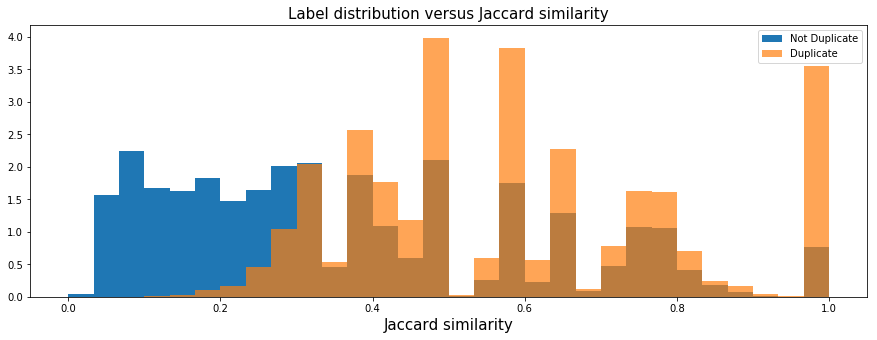

In [23]:
# plotting
plt.figure(figsize=(15, 5))
plt.hist(jaccard[data['is_duplicate'] == 0], bins=30, density=True, label='Not Duplicate')
plt.hist(jaccard[data['is_duplicate'] == 1], bins=30, density=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution versus Jaccard similarity', fontsize=15)
plt.xlabel('Jaccard similarity', fontsize=15)

This looks like a very successful feature. But wait ... This is based on one-hot encoding of features. Can we do better with embeddings?

In [17]:
data["JS"] = jaccard
test["JS"] = test.apply(jaccard_similarity, axis=1, raw=True)

In [18]:
y_data = data['is_duplicate'].values

In [19]:
y_data.shape

(404290,)

In [20]:
data.to_csv(PATH/"data_jaccard.csv", encoding='utf-8', index=False)

In [22]:
test.to_csv(PATH/"test_jaccard.csv", encoding='utf-8', index=False)

## Creating a train and validation sets
The mean of the target value is different in the training data than in the public test set. If you submit a constant predition of 0.369 (mean of the training set) you get a loss of 0.554. What is the mean target of the public test set?  The solution is 0.174. Here we create a validation set with mean target value of 0.174

In [24]:
data.is_duplicate.mean()

0.369197853026293

We have a larger proportion of 1s in the training set than in the test set. A strategy that is often used in these cases is to oversample the 0s. First we split training data into train and val and then we oversample.

In [25]:
from sklearn.model_selection import train_test_split
train, val, y_train, y_val = train_test_split(data, y_data, test_size=0.2, random_state=23)

In [26]:
# how many negatives we need 
print(len(train), len(val)) 

323432 80858


In [27]:
neg_index = np.where(y_train == 0)[0]
neg_index_val = np.where(y_val == 0)[0]

In [28]:
# how many new rows a I need?
p = 0.174
p2 = (1-p)/p
new_train = int((len(train) - neg_index.shape[0])*p2 - neg_index.shape[0])
new_val = int((len(val) - neg_index_val.shape[0])*p2 - neg_index_val.shape[0])
print(new_train, new_val)

361418 92124


In [29]:
train_sample = train.iloc[neg_index].sample(n = new_train, replace = True)
val_sample = val.iloc[neg_index_val].sample(n = new_val, replace = True)

In [30]:
train_balanced = pd.concat((train, train_sample.copy()))
val_balanced = pd.concat((val, val_sample.copy()))

In [31]:
train_balanced["random"] = 1
val_balanced["random"] = 1
features = train_balanced.columns[[6,7]]

In [32]:
y_train = train_balanced["is_duplicate"].values
x_train = train_balanced[features].values
y_val = val_balanced["is_duplicate"].values
x_val = val_balanced[features].values

In [33]:
features

Index(['JS', 'random'], dtype='object')

In [34]:
x_train.shape

(684850, 2)

In [35]:
train_balanced.to_csv(PATH/"train_balanced_jaccard.csv", encoding='utf-8', index=False)
val_balanced.to_csv(PATH/"val_balanced_jaccard.csv", encoding='utf-8', index=False)

### If your kernel dies run this

In [4]:
## read from csv if you kernel dies
train_balanced = pd.read_csv(PATH/"train_balanced_jaccard.csv")
val_balanced = pd.read_csv(PATH/"val_balanced_jaccard.csv")

In [5]:
features = train_balanced.columns[[6,7]]
y_train = train_balanced["is_duplicate"].values
x_train = train_balanced[features].values
y_val = val_balanced["is_duplicate"].values
x_val = val_balanced[features].values

## Training on one feature

To install xgboost in mac `conda install -c conda-forge xgboost `.

In [ ]:
import xgboost as xgb

xgb_pars = {"min_child_weight": 50, "eta": 0.05, "max_depth": 5,
            "subsample": 0.5, "silent" : 1, "nthread": 4,
            "eval_metric": "logloss", "objective": "binary:logistic"}

d_train = xgb.DMatrix(x_train, label=y_train)
d_val = xgb.DMatrix(x_val, label=y_val)

watchlist = [(d_train, 'train'), (d_val, 'valid')]

bst = xgb.train(xgb_pars, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=50)

## Get vobabulary

In [37]:
def get_vocab(list_of_content):
    """Computes Dict of counts of words.
    
    Computes the number of times a word is on a document.
    """
    vocab = defaultdict(float)
    for content in list_of_content:
        line = spacy_tok(content.strip().lower())
        words = set(line)
        for word in words:
            vocab[word] += 1
    return vocab

In [33]:
train_balanced.head()

,id,qid1,qid2,question1,question2,is_duplicate,JS,random
0,83823,141825,141826,How can I get rid of small mosquitos in kitchen?,How can I get rid of tiny roaches in the kitchen?,0,0.428571,1
1,145241,86221,51226,What are the best books for UPSC?,Which are the best books to prepare for IAS exam?,0,0.428571,1
2,238613,350027,350028,Where can I get the second edition of Alan V. ...,"How can I get a free link of a book called, ""S...",0,0.272727,1
3,382628,88337,356439,Do women really like big penises?,Do women prefer circumference or length in penis?,0,0.222222,1
4,256286,371362,371363,Is the Russian Army IRP the same as the Urban ...,Does anyone watch Fubo TV and do they provide ...,0,0.066667,1


In [34]:
list_of_content = list(train_balanced["question1"].values) + list(train_balanced["question1"].values)

In [35]:
list_of_content[:5]

['How can I get rid of small mosquitos in kitchen?',
 'What are the best books for UPSC?',
 'Where can I get the second edition of Alan V. Oppenheim\'s "Signals & Systems: Solutions Manual?"',
 'Do women really like big penises?',
 'Is the Russian Army IRP the same as the Urban Police IRP?']

In [38]:
vocab = get_vocab(list_of_content)

## Initializing embedding layer with Glove embeddings

To get glove pre-trained embeddings:  `wget http://nlp.stanford.edu/data/glove.6B.zip`

In [6]:
globe_path = "/Users/yinterian/teaching/data/Glove/glove.6B.300d.txt"

In [7]:
!head -1 $globe_path

the 0.04656 0.21318 -0.0074364 -0.45854 -0.035639 0.23643 -0.28836 0.21521 -0.13486 -1.6413 -0.26091 0.032434 0.056621 -0.043296 -0.021672 0.22476 -0.075129 -0.067018 -0.14247 0.038825 -0.18951 0.29977 0.39305 0.17887 -0.17343 -0.21178 0.23617 -0.063681 -0.42318 -0.11661 0.093754 0.17296 -0.33073 0.49112 -0.68995 -0.092462 0.24742 -0.17991 0.097908 0.083118 0.15299 -0.27276 -0.038934 0.54453 0.53737 0.29105 -0.0073514 0.04788 -0.4076 -0.026759 0.17919 0.010977 -0.10963 -0.26395 0.07399 0.26236 -0.1508 0.34623 0.25758 0.11971 -0.037135 -0.071593 0.43898 -0.040764 0.016425 -0.4464 0.17197 0.046246 0.058639 0.041499 0.53948 0.52495 0.11361 -0.048315 -0.36385 0.18704 0.092761 -0.11129 -0.42085 0.13992 -0.39338 -0.067945 0.12188 0.16707 0.075169 -0.015529 -0.19499 0.19638 0.053194 0.2517 -0.34845 -0.10638 -0.34692 -0.19024 -0.2004 0.12154 -0.29208 0.023353 -0.11618 -0.35768 0.062304 0.35884 0.02906 0.0073005 0.0049482 -0.15048 -0.12313 0.19337 0.12173 0.44503 0.25147 0.10781 -0.17716 0.0386

In [8]:
def loadGloveModel(gloveFile):
    """ Loads word vectors into a dictionary."""
    f = open(gloveFile,'r')
    word_vecs = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        word_vecs[word] = np.array([float(val) for val in splitLine[1:]])
    return word_vecs

In [10]:
word_vecs = loadGloveModel(globe_path)

In [11]:
print(len(word_vecs.keys()), len(vocab.keys()))

NameError: name 'data_vocab' is not defined

In [ ]:
def delete_rare_words(word_vecs, data_vocab, min_df=2):
    """ Deletes rare words from data_vocab
    
    Deletes words from data_vocab if they are not in word_vecs
    and don't have at least min_df occurrencies in data_vocab.
    """
    words_delete = []
    for word in data_vocab:
        if data_vocab[word] < min_df and word not in word_vecs:
            words_delete.append(word)
    print(words_delete)
    for word in words_delete: data_vocab.pop(word)
    return data_vocab

## Creating Embedding features
You can get Globe embedings from https://nlp.stanford.edu/projects/glove/

In [1]:
globe_path = "/data/yinterian/Glove/glove.6B.50d.txt"
globe_path = "/data/yinterian/Glove/glove.6B.300d.txt"
globe_path = "/Users/yinterian/teaching/data/Glove/glove.6B.300d.txt"

In [35]:
def load_word_embedings(file =globe_path):
    embeddings = {}
    with open(file, 'r') as infile:
        for line in infile:
            values = line.split()
            embeddings[values[0]] = np.asarray(values[1:], dtype='float32')
    return embeddings

In [36]:
embeddings = load_word_embedings()

In [37]:
len(embeddings.keys())

400000

In [38]:
def sentence_features(s, embeddings=embeddings, emb_size=300):
    words = get_non_stopwords(s)
    words = [w for w in words if w.isalpha() and w in embeddings]
    if len(words) == 0:
        return np.zeros(3 * emb_size)
    M = [embeddings[w] for w in words]
    M = np.array(M)
    v_mean = M.mean(axis=0)
    v_min = M.min(axis=0)
    v_max = M.max(axis=0)
    return np.hstack([v_mean, v_min, v_max])

In [39]:
def sentence_features_v2(s, embeddings=embeddings, emb_size=300):
    words = get_non_stopwords(s)
    words = [w for w in words if w.isalpha() and w in embeddings]
    if len(words) == 0:
        return np.hstack([np.zeros(emb_size)])
    M = np.array([embeddings[w] for w in words])
    return M.mean(axis=0)

In [40]:
w = sentence_features(data.loc[0, "question1"])
w.shape

(900,)

In [41]:
train_balanced.head()

,id,qid1,qid2,question1,question2,is_duplicate,JS,random
83823,83823,141825,141826,How can I get rid of small mosquitos in kitche...,How can I get rid of tiny roaches in the kitch...,0,0.499999,1
145241,145241,86221,51226,What are the best books for UPSC ?,Which are the best books to prepare for IAS ex...,0,0.428571,1
238613,238613,350027,350028,Where can I get the second edition of Alan V ....,"How can I get a free link of a book called , ...",0,0.200000,1
382628,382628,88337,356439,Do women really like big penises ?,Do women prefer circumference or length in pen...,0,0.200000,1
256286,256286,371362,371363,Is the Russian Army IRP the same as the Urban ...,Does anyone watch Fubo TV and do they provide ...,0,0.062500,1


In [42]:
# create sentence vectors for question1
x_train_q1 = np.array([sentence_features_v2(x) for x in train_balanced["question1"].values])
x_valid_q1 = np.array([sentence_features_v2(x) for x in val_balanced["question1"].values])

In [43]:
x_train_q2 = np.array([sentence_features_v2(x) for x in train_balanced["question2"].values])
x_valid_q2 = np.array([sentence_features_v2(x) for x in val_balanced["question2"].values])

In [44]:
train_balanced["emb_dist"] = np.linalg.norm(x_train_q1 - x_train_q2, axis=1) 

In [45]:
val_balanced["emb_dist"] = np.linalg.norm(x_valid_q1 - x_valid_q2, axis=1) 

Text(0.5,0,'Embedding Distance')

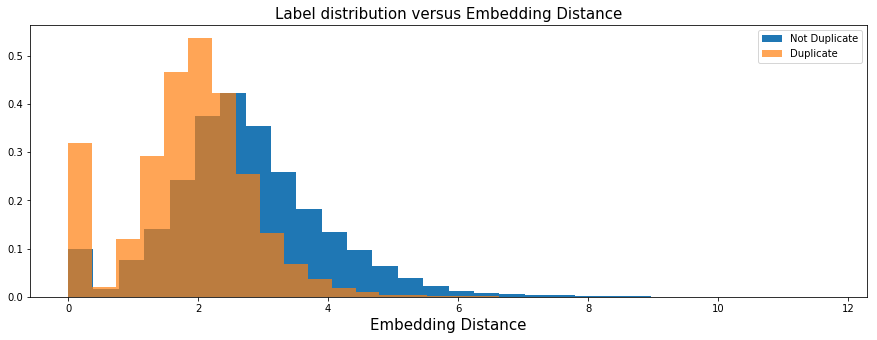

In [46]:
plt.figure(figsize=(15, 5))
plt.hist(train_balanced.loc[train_balanced["is_duplicate"] == 0, "emb_dist"], bins=30, normed=True, label='Not Duplicate')
plt.hist(train_balanced.loc[train_balanced["is_duplicate"] == 1, "emb_dist"], bins=30, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution versus Embedding Distance', fontsize=15)
plt.xlabel('Embedding Distance', fontsize=15)

In [47]:
features = train_balanced.columns[[7,8]]
features

Index(['random', 'emb_dist'], dtype='object')

In [48]:
y_train = train_balanced["is_duplicate"].values
x_train = train_balanced[features].values
y_val = val_balanced["is_duplicate"].values
x_val = val_balanced[features].values

In [49]:
import xgboost as xgb

xgb_pars = {"min_child_weight": 50, "eta": 0.05, "max_depth": 8,
            "subsample": 0.8, "silent" : 1, "nthread": 4,
            "eval_metric": "logloss", "objective": "binary:logistic"}

d_train = xgb.DMatrix(x_train, label=y_train)
d_val = xgb.DMatrix(x_val, label=y_val)

watchlist = [(d_train, 'train'), (d_val, 'valid')]

bst = xgb.train(xgb_pars, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=50)

[0]	train-logloss:0.669922	valid-logloss:0.669991
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[50]	train-logloss:0.418536	valid-logloss:0.419904
[100]	train-logloss:0.413725	valid-logloss:0.415726
[150]	train-logloss:0.413323	valid-logloss:0.415698
[200]	train-logloss:0.413075	valid-logloss:0.415667
[250]	train-logloss:0.412835	valid-logloss:0.415661
[300]	train-logloss:0.412612	valid-logloss:0.415647
[350]	train-logloss:0.412386	valid-logloss:0.415617


In [50]:
x_train = x_train_q1 - x_train_q2
x_val = x_valid_q1 - x_valid_q2

In [56]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_val = xgb.DMatrix(x_val, label=y_val)

xgb_pars = {"min_child_weight": 50, "eta": 0.03, "max_depth": 7,
            "subsample": 0.5, "silent" : 1, "colsample_bytree": 0.3,
            "nthread": 4,
            "eval_metric": "logloss", "objective": "binary:logistic"}

watchlist = [(d_train, 'train'), (d_val, 'valid')]

bst = xgb.train(xgb_pars, d_train, 700, watchlist, early_stopping_rounds=50, verbose_eval=50)

[0]	train-logloss:0.67974	valid-logloss:0.679788
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[50]	train-logloss:0.446806	valid-logloss:0.44841
[100]	train-logloss:0.41689	valid-logloss:0.419967
[150]	train-logloss:0.407998	valid-logloss:0.412569
[200]	train-logloss:0.403154	valid-logloss:0.409191
[250]	train-logloss:0.399549	valid-logloss:0.406852
[300]	train-logloss:0.395191	valid-logloss:0.404188
[350]	train-logloss:0.391366	valid-logloss:0.401934
[400]	train-logloss:0.38732	valid-logloss:0.399657
[450]	train-logloss:0.383902	valid-logloss:0.397828
[500]	train-logloss:0.38017	valid-logloss:0.395851
[550]	train-logloss:0.376722	valid-logloss:0.394081
[600]	train-logloss:0.373335	valid-logloss:0.392409
[650]	train-logloss:0.370348	valid-logloss:0.391005


## Bag of world model 

In [ ]:
class SentenceCNN(nn.Module):
    
    def __init__(self, V, D, glove_weights):
        super(SentenceCNN, self).__init__()
        self.glove_weights = glove_weights
        self.embedding = nn.Embedding(V, D, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(self.glove_weights))
        self.embedding.weight.requires_grad = False ## freeze embeddings
        
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(300, 1)
        
    def forward(self, x1, x2):
        x1 = self.embedding(x1)
        x2 = self.embedding(x1)
        
        out = torch.cat([x3, x4, x5], 2)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        return self.fc(out)

## References
* https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb
* https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle/
* https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/